<a href="https://colab.research.google.com/github/cheerswym/DeepLearning/blob/master/detr_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Detection Transformer Tutorial** 
---

# Understanding The DEtection TRansformer (DETR)

## Overview of the model

The Detection Transformer was developed by the Facebook Research team and introduced in [[1]](http://arxiv.org/abs/1906.05909). DETR works by generating a *set* of features from an input image, and then using a transformer to predict the location (surrounding bounding box) of predefined number of objects as well as their respective class. Each component of the model is explained in detail below. 


## Model Architecture

<p align="center">
  <img src="https://miro.medium.com/max/967/1*ROEemTct0f47Y2kDlAAF4Q.png" alt>
  <em><p align="center">DETR Architecture</p></em>
</p>

The DETR model consists of a pretrained **CNN backbone**, which produces a set of lower dimensional set of features. These features are then scaled and added to a positional encoding, which is fed into a **Transformer** consisting of an **Encoder** and a **Decoder** in a manner quite similar to the Encoder-Decoder transformer described in [[2]](http://arxiv.org/abs/1706.03762). The output of the decoder is then fed into a fixed number of **Prediction Heads** which consist of a predefined number of feed forward networks. Each output of one of these prediction heads consists of a *class prediction*, as well as a predicted *bounding box*. The loss is calculated by computing the bipartite matching loss.

### The CNN Backbone

Assume that our input image $x_{im}\in \mathbb{R}^{3\times W_0 \times H_0}$. In other words, $x_{im}$ is an RGB image with height $H_0$, width $W_0$, and $3$ color channels. The CNN backbone consists of a (pretrained) CNN, which we use to generate $C$ lower dimensional features having width $W$ and height $H$ (*In practice, we set $C=2048$, $W=W_0/32$ and $H=H_0/32$*). <br>

This leaves us with $C$ two-dimensional features, and since we will be passing these features into a transformer, each feature must be reformatted in a way that will allow the encoder to process each feature as a sequence. This is done by flattening the feature matrices into an $H\cdot W$ vector, and then concattenating each one. <br>

The flattened convolutional features are added to a spatial positional encoding which can either be learned, or pre-defined.

<p align="center">
  <img src="https://raw.githubusercontent.com/jacobbriones1/detr_explained/main/media/unrolled.png" alt>
  <em><p align="center">Unrolled Image Features from Convolutional features</p></em>
</p>

### The Transformer Architecture

<p align="center">
  <img src="https://raw.githubusercontent.com/jacobbriones1/detr_explained/main/media/detr_transformer.png" width="500" height="450" alt>
  <em><p align="center">The DETR Transformer</p></em>
</p>

<u>**The Encoder**</u><br>
The Encoder consists of $N$ *Encoder Layers*. Each encoder layer consits of a Multi-Head Self-Attention Layer, an *Add & Norm* Layer, a Feed Forward Neural Network, and another *Add & Norm* layer. This is nearly identical to the original Transformer Encoder from [[2]](http://arxiv.org/abs/1706.03762) except we are only adding our spatial positional encoding to the Key and Queue matrices. Also note that we add the spatial encoding tho the Query matrix of the decoder after the decoder's first MHSA and Normalization layer. 

<u>**The Decoder**</u><br>
The decoder is more complicated than the Encoder. The **object queries** consist of a set of $N$ vectors which are added to the key and query matrices of the decoder. The output of the encoder and the spatial positional encoding is added to the key matrix (before the Multi-Head Attention layer). 

### The Prediction Heads

The prediction heads consists of two Feed-Forward networks which compute class predictions and bounding boxes. Note that the number of predictions is equal to the number of object queries. If there are less predictions than the number of object queries, then the outputted class will be $\varnothing$


---
# Minimal DETR Implementation


In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet50


class SimpleDETR(nn.Module):
  """
  Minimal Example of the Detection Transformer model with learned positional embedding
  """

  def __init__(self, num_classes, hidden_dim, num_heads,
               num_enc_layers, num_dec_layers):
    
    super(SimpleDETR,self).__init__()
    self.num_classes = num_classes
    self.hidden_dim = hidden_dim
    self.num_heads = num_heads
    self.num_enc_layers = num_enc_layers
    self.num_dec_layers = num_dec_layers 

    self.backbone = nn.Sequential(
        *list(resnet50(pretrained=True).children())[:-2])

    self.conv = nn.Conv2d(2048, hidden_dim, 1)

    self.transformer = nn.Transformer(hidden_dim, num_heads,
                                      num_enc_layers, num_dec_layers)
    
    self.to_classes = nn.Linear(hidden_dim, num_classes+1)
    self.to_bbox = nn.Linear(hidden_dim, 4)

    self.object_query = nn.Parameter(torch.rand(100, hidden_dim))

    self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
    self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
    self.states = dict({'conv_features':None,'H':None,'W':None,
                        'pos_enc':None,'object_query':self.object_query,
                        'pred_classes':None,'pred_bboxes':None})
    
  def forward(self, X):
    X = self.backbone(X)
    h = self.conv(X)
    self.conv_features = h.data

    self.states['conv_features'] = h.data

    H, W = h.shape[-2:]
    self.states['H']=H
    self.states['W']=W
    

    pos_enc = torch.cat([
                         self.col_embed[:W].unsqueeze(0).repeat(H,1,1),
                         self.row_embed[:H].unsqueeze(1).repeat(1,W,1)
                         ],
                    dim=-1).flatten(0,1).unsqueeze(1)

    self.states['pos_enc'] = pos_enc.data
    
    h = self.transformer(pos_enc + h.flatten(2).permute(2,0,1),
                         self.object_query.unsqueeze(1))
        
    class_pred = self.to_classes(h)
    bbox_pred = self.to_bbox(h).sigmoid()

    self.states['pred_classes']=class_pred.detach().data
    self.states['pred_bbox']=bbox_pred.detach().data

    return class_pred, bbox_pred

In [ ]:
detr = SimpleDETR(1,256,8,6,6)
X = torch.rand(1,3,100,100)
cls, box = detr(X)
box.size()

torch.Size([100, 1, 4])

## Bipartite Matching Loss

Let $\hat{y}=\{\hat{y}_i\}_{i=1}^N$ be the set of predictions where $\hat{y}_y=(\hat{c}_i,\hat{b}_i)$ is the tuple consisting of the predicted class (which can be the empty class) and a bounding box $\hat{b}_i=(\bar{x}_i,\bar{y}_i,w_i,h_i)$ where the bar notation represents the midpoint between endpoints, and $w_i$ and $h_i$ are the width and height of the box, respectively. <br>

Let $y$ denote the ground truth set. Suppose that the loss between $y$ and $\hat{y}$ is $L$, and the loss between each $y_i$ and $\hat{y}_i$ is $L_i$. Since we are working on the level of sets, the loss $L$ must be permutation invariant, meaning that we will get the same loss regardless of how we order the predictions. Thus, we want to find a permutation $\sigma\in S_N$ which maps the indices of the predictions to the indices of the ground truth targets. Mathematically, we are solving for


$$
\hat{\sigma}=\arg\min\limits_{\sigma\in S_N}^{} \sum\limits_{i=1}^N L_{i}(y_i, \hat{y}_{\sigma(i)}) \tag{1}
$$

The process of computing $\hat{\sigma}$ is called finding an optimal **bipartite matching**. This can be found using the **Hungarian Algorithm**. But in order to find the optimal matching, we need to actually define a loss function which computes the *matching cost* between $y_i$ and $\hat{y}_{\sigma(i)}$. 

Recall that our predictions consist of both a bounding box and a class. Let's now assume that the class prediction is actually a probability distribution over the set of classes (we take the softmax of the output to produce this). Then the total loss for the $i$th prediction will be the loss that is generated from class prediction and the loss generated from the bounding box prediction. The authors of [[1]](http://arxiv.org/abs/1906.05909) define this loss as the difference in the bounding box loss and the class prediction probability:

$$
\mathcal{L}_{match}(y_i,\hat{y}_{\sigma({i})})=
-\mathbb{I}_{\{c_i\neq \varnothing\}}\hat{p}_i(c_i) +
\mathbb{I}_{\{c_i\neq \varnothing\}}\mathcal{L}_{box}({b}_i,\hat{b}_{\sigma({i})}) \tag{2}
$$

where $\hat{p}_i(c_i)$ is the $\arg\max$ of the logits from $c_i$ and $\mathcal{L}_{box}$ is the loss resulting from the bounding box prediction. The above also states that the match loss is $0$ if $c_i=\varnothing$. 
The box loss is computed as a linear combination of the $L_1$ loss (displacement) and the **Generalized Intersection-Over-Union** (GIOU) loss between the predicted and ground truth bounding box. Also, if you imagine two bounding boxes which don't intersect, then the box error will not provide any meaningful context (as we can see from the definition of the box loss below). 

$$
\mathcal{L}_{box}({b}_i,\hat{b}_{\sigma({i})}) =
\lambda_{iou}\mathcal{L}_{iou}({b}_i,\hat{b}_{\sigma({i})}) +
 \lambda_{L1}\|b_{\sigma(i)}-\hat{b}_i\|_1\tag{3}
$$

Where in the above equation the parameters $\lambda_{iou}$ and $\lambda_{L_1}$ are scalar hyperparameters. Notice that this sum is also a combination of errors generated from area and distance. Why does this make sense? 
It makes sense to think of equation $(3)$ as a *total cost* associated with the prediction $\hat{b}_{\sigma(i)}$ where the *price* of area errors is $\lambda_{iou}$ and the *price* of distance errors is $\lambda_{L1}$.
Now let's actually define the GIOU loss function. It is defined as follows:

$$
\mathcal{L}_{iou}({b}_i,\hat{b}_{\sigma({i})}) =
1-\Biggl(\frac{|b_{\sigma(i)}\cap \hat{b}_i|}{|b_{\sigma(i)}\cup\hat{b}_i|} - 
\frac{|B(b_{\sigma(i)},\hat{b}_i)\setminus b_{\sigma(i)}\cup \hat{b}_i|}{|B(b_{\sigma(i)},\hat{b}_i)|} \Biggr)\tag{4}
$$

The first term in the parenthesis is the **intersection over union** (IOU) function which is depicted below. The term $B(b_i, \hat{b}_i)$ denotes the *largest bounding box* containing $b_i$ and $\hat{b}_i$, and $|\cdot|$ represents area. 


<p align="center">
  <img src="https://www.researchgate.net/publication/335876570/figure/fig2/AS:804291526795265@1568769451765/Intersection-over-Union-IOU-calculation-diagram.png" height="450" width="650" alt>
  <em><p align="center">IOU Function (image from [3]) </p></em>
</p>

Since we are predicting classes from a given number of known classes, then class prediction is a classification problem, and thus we can use cross entropy loss for the class prediction error. We define the hungarian loss function as the the sum of each $N$ prediction losses:

$$\mathcal{L}_{Hungarian}(y,\hat{y})=
\sum_{i=0}^N\Bigl[-\log{ \hat{p}_i(c_i)} + 
\mathbb{I}_{\{c_i\neq \varnothing\}}\mathcal{L}_{box}({b}_i,\hat{b}_{\sigma({i})})\Bigr]\tag{5}$$

$$\boxed{\boxed{
\begin{align}
\mathcal{L}_{match}(y_i,\hat{y}_{\sigma({i})})&=
-\mathbb{I}_{\{c_i\neq \varnothing\}}\hat{p}_i(c_i) +
\mathbb{I}_{\{c_i\neq \varnothing\}}\mathcal{L}_{box}({b}_i,\hat{b}_{\sigma({i})})\\

\mathcal{L}_{Hungarian}(y,\hat{y})&=
\sum_{i=0}^N\Bigl[-\log{ \hat{p}_i(c_i)} + 
\mathbb{I}_{\{c_i\neq \varnothing\}}\mathcal{L}_{box}({b}_i,\hat{b}_{\sigma({i})})\Bigr]\\

\mathcal{L}_{box}({b}_i,\hat{b}_{\sigma({i})}) &= 
\lambda_{iou}\mathcal{L}_{iou}({b}_i,\hat{b}_{\sigma({i})}) +
 \lambda_{L1}\|b_{\sigma(i)}-\hat{b}_i\|_1\\

\mathcal{L}_{iou}({b}_i,\hat{b}_{\sigma({i})}) &= 
1-\Biggl(\frac{|b_{\sigma(i)}\cap \hat{b}_i|}{|b_{\sigma(i)}\cup\hat{b}_i|} - 
\frac{|B(b_{\sigma(i)},\hat{b}_i)\setminus b_{\sigma(i)}\cup \hat{b}_i|}{|B(b_{\sigma(i)},\hat{b}_i)|} \Biggr)\\
\end{align}}}
$$


---
# Using the pretrained DETR for Object Detection with PyTorch


## Import Necessary Modules

In [ ]:
#@title
import torch
from torchvision import transforms as T

import requests # for loading images from web
from PIL import Image, ImageDraw # for viewing images and drawing bounding boxes

from IPython.display import display, Markdown, Latex
from termcolor import colored
import matplotlib.pyplot as plt

## Load the model from PyTorch

Here we use torchhub to load the pretrained model for object detection from the Facebook Research github repository. 

In [ ]:
model = torch.hub.load('facebookresearch/detr','detr_resnet50',pretrained=True)

if torch.cuda.is_available():
  torch.device('cuda')
  model = model.cuda()

Downloading: "https://github.com/facebookresearch/detr/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache/torch/hub/checkpoints/detr-r50-e632da11.pth



## Get an Image

We can load any image from the web by using the requests library as well as PIL. 

In [ ]:
url = 'https://www.tempetourism.com/wp-content/uploads/Postino-Downtown-Tempe-2.jpg' #@param {type: "string"}

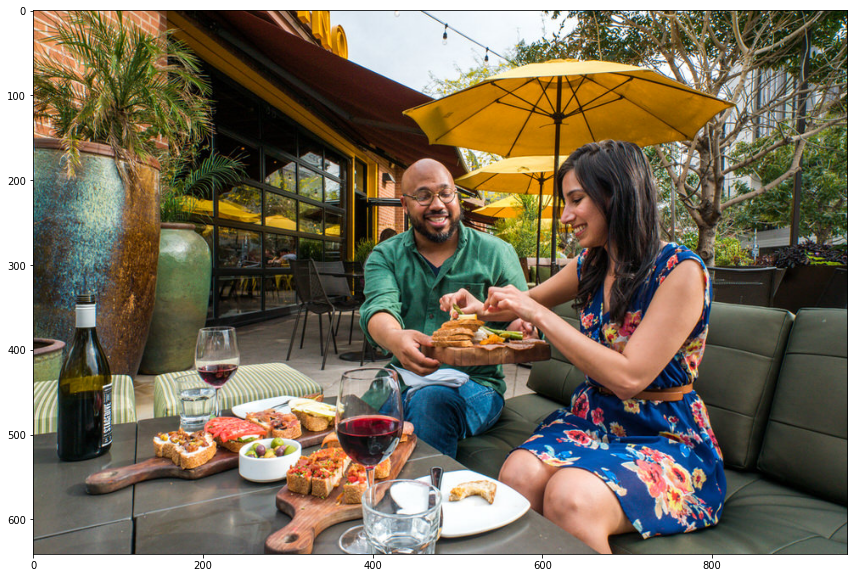

In [ ]:
#@title Display Image
im = Image.open(requests.get(url, stream=True).raw)
fig = plt.figure(figsize=(15,10))
plt.imshow(im)
plt.show()

## Setting up the Object Detection Pipeline

### ImageTransforms

As a preprocessing step, we resize our image, convert it to a tensor, and then normalize the pixel values below:


In [ ]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [ ]:
img_tensor = transform(im)

### Object Classes

We manually define the names of each COCO class, as well as the colors that we will use for each bounding box.

In [ ]:
# COCO classes
CLASSES = ['N/A', 'Person', 'Bicycle', 'Car', 'Motorcycle', 'Airplane', 'Bus', 
           'Train', 'Truck', 'Boat', 'Traffic-Light', 'Fire-Hydrant', 'N/A', 'Stop-Sign',
           'Parking Meter', 'Bench', 'Bird', 'Cat', 'Dog', 'Horse', 'Sheep', 'Cow', 'Elephant',
           'Bear', 'Zebra', 'Giraffe', 'N/A', 'Backpack', 'Umbrella', 'N/A', 'N/A', 'Handbag', 
           'Tie', 'Suitcase', 'Frisbee', 'Skis', 'Snowboard', 'Sports-Ball', 'Kite', 'Baseball Bat',
           'Baseball Glove', 'Skateboard', 'Surfboard', 'Tennis Racket', 'Bottle', 'N/A', 
           'Wine Glass', 'Cup', 'Fork', 'Knife', 'Spoon', 'Bowl', 'Banana', 'Apple', 'Sandwich', 
           'Orange', 'Broccoli', 'Carrot', 'Hot-Dog', 'Pizza', 'Donut', 'Cake', 'Chair', 'Couch', 
           'Potted Plant', 'Bed', 'N/A', 'Dining Table', 'N/A','N/A', 'Toilet', 'N/A', 'TV', 'Laptop',
           'Mouse', 'Remote', 'Keyboard', 'Cell-Phone', 'Microwave', 'Oven', 'Toaster', 
           'Sink', 'Refrigerator', 'N/A', 'Book', 'Clock', 'Vase', 'Scissors', 'Teddy-Bear',
           'Hair-Dryer', 'Toothbrush']

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [ ]:
len(CLASSES)

91

## The Bounding Box

The bounding boxes which are output from the model are of the form  $(x,y,w,h)$, where $(x,y)$ are in the units square $[0,1]^2$ and $h,w$ are the width and height of the bounding box. The coordinate $(x,y)$ represents the center of the object in the bounding box. In other words, the point $(x,y)$ is in the center of the bounding box. If the image is of size $W\times H$, then we can find the cordinates of the bounding box as follows:

$$
\begin{align}
\boxed{
x_0=W\cdot(x-w/2),\text{   }\text{  } y_0=H\cdot(y- h/2)}\\~\\
\boxed{
x_1=W\cdot(x +  w/2),\text{   }\text{  } y_1=H\cdot(y + h/2)}
\end{align}$$


### Get Box Coordinates

In [ ]:
# Get coordinates (x0, y0, x1, y0) from model output (x, y, w, h)
def get_box_coords(boxes):
    x, y, w, h = boxes.unbind(1)
    x0, y0 = (x - 0.5 * w), (y - 0.5 * h)
    x1, y1 = (x + 0.5 * w), (y + 0.5 * h)
    box = [x0, y0, x1, y1]
    return torch.stack(box, dim=1)

In [ ]:
output['pred_boxes'].shape

torch.Size([1, 100, 4])

### Scale Bounding Box Size

In [ ]:
# Scale box from [0,1] x [0,1] to [0, width] x [0, height]
def scale_boxes(output_box, width, height):
  box_coords = get_box_coords(output_box)
  scale_tensor = torch.Tensor([width, height, width, height]).to(torch.cuda.current_device())
  return box_coords * scale_tensor

## Detect Objects 

Now we need a function to encapsulate our object detection pipeline. The `detect` function returns the probability that objects belongs to the given classes, and the associated bounding boxes.

In [ ]:
def detect(im, model, transform):
    device = torch.cuda.current_device()
    width = im.size[0]
    height = im.size[1]
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)
    img = img.to(device)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.85

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = scale_boxes(outputs['pred_boxes'][0, keep], width, height)
    return probas[keep], bboxes_scaled

In [ ]:
probs, bboxes = detect(im, model, transform)
output=model(img_tensor.unsqueeze(0).to(torch.cuda.current_device()))

In [ ]:
output['pred_logits'].size()

torch.Size([1, 100, 92])

## Visualize Results

In [ ]:
def plot_results(pil_img, prob, boxes,labels=True):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for prob, (x0, y0, x1, y1), color in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((x0, y0), x1 - x0, y1 - y0,
                                   fill=False, color=color, linewidth=2))
        cl = prob.argmax()
        text = f'{CLASSES[cl]}: {prob[cl]:0.2f}'
        if labels:
          ax.text(x0, y0, text, fontsize=15,
                bbox=dict(facecolor=color, alpha=0.75))
    plt.axis('off')
    plt.show()

### With Labels

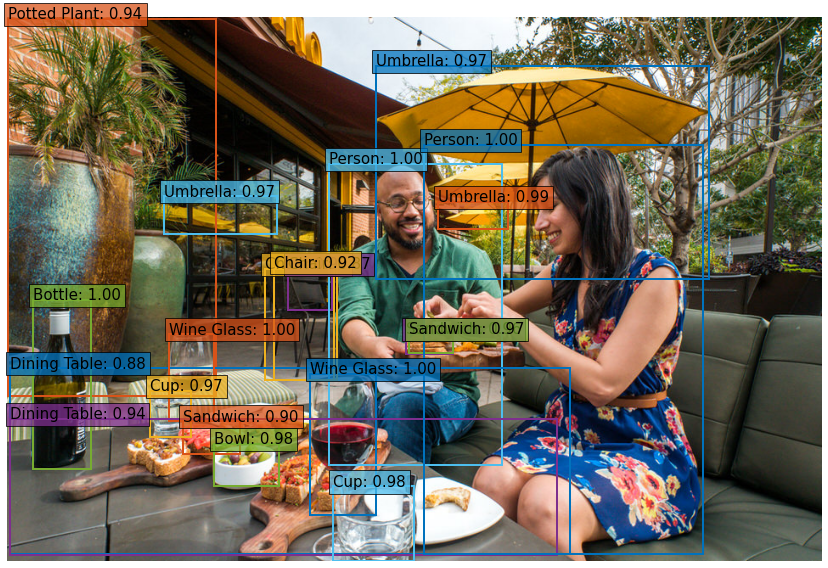

In [ ]:
plot_results(im, probs, bboxes)

### Without Labels

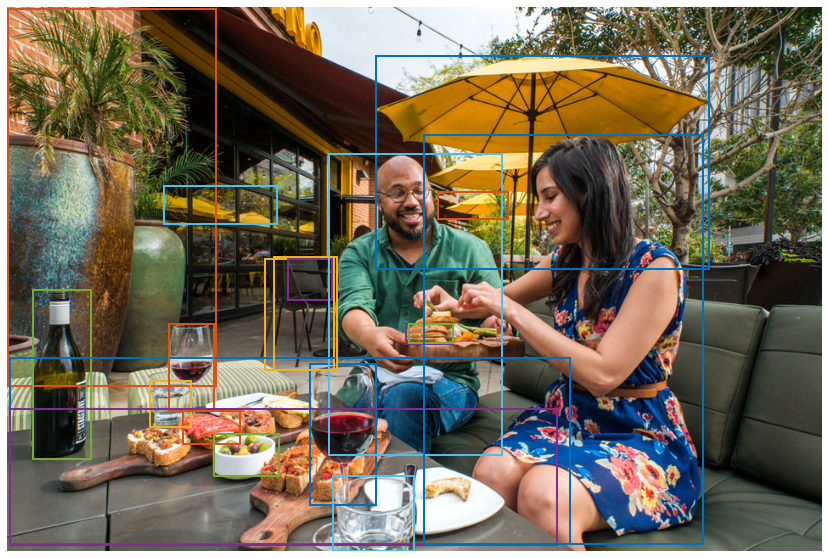

In [ ]:
plot_results(im, probs, bboxes, False)

---
# References

1. \* https://arxiv.org/abs/2005.12872

2. Vaswani, Ashish, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, and Illia Polosukhin. “Attention Is All You Need.” ArXiv:1706.03762 [Cs], December 5, 2017. http://arxiv.org/abs/1706.03762.

3. https://www.researchgate.net/publication/335876570/figure/fig2/AS:804291526795265@1568769451765/Intersection-over-Union-IOU-calculation-diagram.png



<p align="center">
  <kbd>
  <img src="https://raw.githubusercontent.com/jacobbriones1/detr_explained/main/media/Attention.png" width="600" alt>
  </kbd>
  <em><p align="center">Multi-Head Attention Operation</p></em>
</p>
